In [1]:
from download_gmi_data import get_gmi_data
# get_gmi_data(mon=[10])
import sys

In [2]:
import os
folder_name = ''
files = [f for f in os.listdir(folder_name+'daily_data/') if 'f35' in f]

In [3]:
import numpy as np
from gmi_daily_v8 import GMIdaily
from gmi_averaged_v8 import GMIaveraged

def read_data(folder_name=folder_name+'daily_data/', file_name='f35_20231001v8.2_d3d.gz'):
    file_path = '/'.join([folder_name, file_name])
    avg = False
    if 'd3d' in file_name:
        dataset = GMIaveraged(file_path, missing=np.nan)
        avg = True
    else:
        dataset = GMIdaily(file_path, missing=np.nan)
    if not dataset.variables: sys.exit('problem reading file')
    return (avg, dataset)

In [4]:
lat_deg_to_idx = lambda x: int((x + 90)*4)
lon_deg_to_idx = lambda x: int(x*4)
lat_idx_to_deg = lambda x: x//4 - 90
lon_idx_to_deg = lambda x: x//4

# Hawaii
radiosonde_latlon = (22, 200)
radiosonde_ilatilon = (lat_deg_to_idx(radiosonde_latlon[0]), lon_deg_to_idx(radiosonde_latlon[1]))

buffer = 10
ilat_min = lat_deg_to_idx(radiosonde_latlon[0]-buffer)
ilon_min = lon_deg_to_idx(radiosonde_latlon[1]-buffer)
ilat_max = lat_deg_to_idx(radiosonde_latlon[0]+buffer)
ilon_max = lon_deg_to_idx(radiosonde_latlon[1]+buffer)

In [5]:
%%time

from turbulence_structure_estimator import TurbulenceStructureEstimator
import numpy as np
import re
from datetime import datetime, timedelta

time_betahat_dict = {}
for f in files:
    date = re.search(r'f35_(\d{4})(\d{2})(\d{2})v8\.2\.gz', f)
    yyyy, mm, dd = date.group(1), date.group(2), date.group(3)
    gmt_midnight = datetime(int(yyyy), int(mm), int(dd))

    avged, dataset = read_data(file_name=f)
    tse_asc = TurbulenceStructureEstimator(dataset.variables['vapor'][0, :, :]*dataset._get_scale('vapor'), 2, \
                                    ilat_min=ilat_min, ilon_min=ilon_min, \
                                    ilat_max=ilat_max, ilon_max=ilon_max,
                                    verbose=False)
    tse_desc = TurbulenceStructureEstimator(dataset.variables['vapor'][1, :, :]*dataset._get_scale('vapor'), 2, \
                                    ilat_min=ilat_min, ilon_min=ilon_min, \
                                    ilat_max=ilat_max, ilon_max=ilon_max,
                                    verbose=False)
    ilatilon_betaciwv_dict_asc = tse_asc.run_algorithm()
    ilatilon_betaciwv_dict_desc = tse_desc.run_algorithm()

    beta_asc = ilatilon_betaciwv_dict_asc[radiosonde_ilatilon[0], radiosonde_ilatilon[1]][0]
    beta_desc = ilatilon_betaciwv_dict_desc[radiosonde_ilatilon[0], radiosonde_ilatilon[1]][0]

    if not np.isnan(beta_asc):
        time_asc = dataset._get_scale('time')*float(np.nanmean(dataset.variables['time'][0, \
                                radiosonde_ilatilon[0]-buffer:radiosonde_ilatilon[0]+buffer, \
                                radiosonde_ilatilon[1]-buffer:radiosonde_ilatilon[1]+buffer].flatten()))
        time_delta = timedelta(minutes=time_asc)
        desired_datetime = gmt_midnight + time_delta
        time_betahat_dict[desired_datetime] = beta_asc

    if not np.isnan(beta_desc):
        time_desc = dataset._get_scale('time')*float(np.nanmean(dataset.variables['time'][1, \
                                radiosonde_ilatilon[0]-buffer:radiosonde_ilatilon[0]+buffer, \
                                radiosonde_ilatilon[1]-buffer:radiosonde_ilatilon[1]+buffer].flatten()))
        time_delta = timedelta(minutes=time_desc)
        desired_datetime = gmt_midnight + time_delta
        time_betahat_dict[desired_datetime] = beta_desc



C:\Users\Angela\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Angela\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Angela\Documents\clasp585\turbulence_structure_estimator.py:30: RuntimeWarning: divide by zero encountered in log
  y_s = np.log(diwv_s)


Wall time: 13min 43s


In [6]:
# import pickle
# with open('time_betahat_dict.pkl', 'wb') as file:
#     pickle.dump(time_betahat_dict, file)
# with open('time_betahat_dict.pkl', 'rb') as file:
#     time_betahat_dict = pickle.load(file)

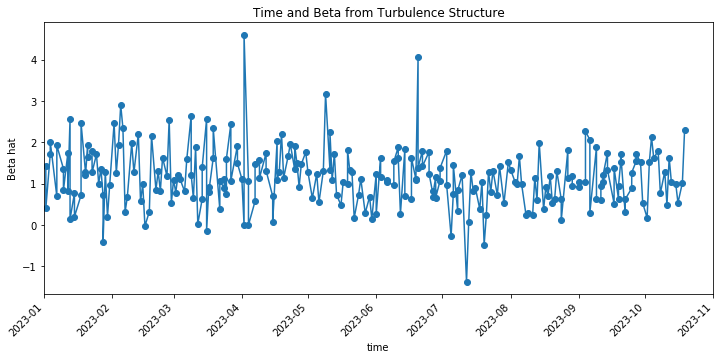

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

times = sorted(time_betahat_dict.keys())
# print(times)
values = [time_betahat_dict[key] for key in times]

figure_size = (12,5)
plt.figure(figsize=figure_size)
plt.plot(times, values, 'o-')
plt.xticks(rotation=45, ha='right')
plt.xlim([datetime(2023, 1, 1, 0, 0, 0), datetime(2023, 11, 1, 0, 0, 0)])
plt.title('Time and Beta from Turbulence Structure')
plt.xlabel('time')
plt.ylabel('Beta hat')
plt.show()

In [7]:
from radiosonde import Radiosonde
import matplotlib.pyplot as plt

radiosonde = Radiosonde(folder_name+'radiosonde_data_jan23_oct23.txt')

fraction = 0.5

dates = [reading.datetime for reading in radiosonde.readings]
all_hfs = [reading.calc_frac_height(fraction=fraction) for reading in radiosonde.readings]

figure_size = (12,5)
plt.figure(figsize=figure_size)
plt.plot(dates, all_hfs, 'o-')
plt.xticks(rotation=45, ha='right')
plt.xlim([datetime(2023, 1, 1, 0, 0, 0), datetime(2023, 11, 1, 0, 0, 0)])
plt.title('Time vs '+str(int(fraction*100))+'% Fractional Height')
plt.xlabel('Time')
plt.ylabel('Fractional Height (m)')
plt.show()


ModuleNotFoundError: No module named 'radiosonde'

In [ ]:
def calc_turbulence_structure(files=files, ilat_min=ilat_min, ilon_min=ilon_min, ilat_max=ilat_max, ilon_max=ilon_max):
    time_betahat_dict = {}
    for f in files:
        date = re.search(r'f35_(\d{4})(\d{2})(\d{2})v8\.2\.gz', f)
        yyyy, mm, dd = date.group(1), date.group(2), date.group(3)
        gmt_midnight = datetime(int(yyyy), int(mm), int(dd))

        avged, dataset = read_data(file_name=f)
        tse_asc = TurbulenceStructureEstimator(dataset.variables['vapor'][0, :, :]*dataset._get_scale('vapor'), 2, \
                                        ilat_min=ilat_min, ilon_min=ilon_min, \
                                        ilat_max=ilat_max, ilon_max=ilon_max,
                                        verbose=False)
        tse_desc = TurbulenceStructureEstimator(dataset.variables['vapor'][1, :, :]*dataset._get_scale('vapor'), 2, \
                                        ilat_min=ilat_min, ilon_min=ilon_min, \
                                        ilat_max=ilat_max, ilon_max=ilon_max,
                                        verbose=False)
        ilatilon_betaciwv_dict_asc = tse_asc.run_algorithm()
        ilatilon_betaciwv_dict_desc = tse_desc.run_algorithm()

        beta_asc = ilatilon_betaciwv_dict_asc[radiosonde_ilatilon[0], radiosonde_ilatilon[1]][0]
        beta_desc = ilatilon_betaciwv_dict_desc[radiosonde_ilatilon[0], radiosonde_ilatilon[1]][0]

        if not np.isnan(beta_asc):
            time_asc = dataset._get_scale('time')*float(np.nanmean(dataset.variables['time'][0, \
                                    radiosonde_ilatilon[0]-buffer:radiosonde_ilatilon[0]+buffer, \
                                    radiosonde_ilatilon[1]-buffer:radiosonde_ilatilon[1]+buffer].flatten()))
            time_delta = timedelta(minutes=time_asc)
            desired_datetime = gmt_midnight + time_delta
            time_betahat_dict[desired_datetime] = beta_asc

        if not np.isnan(beta_desc):
            time_desc = dataset._get_scale('time')*float(np.nanmean(dataset.variables['time'][1, \
                                    radiosonde_ilatilon[0]-buffer:radiosonde_ilatilon[0]+buffer, \
                                    radiosonde_ilatilon[1]-buffer:radiosonde_ilatilon[1]+buffer].flatten()))
            time_delta = timedelta(minutes=time_desc)
            desired_datetime = gmt_midnight + time_delta
            time_betahat_dict[desired_datetime] = beta_desc
    return time_betahat_dict

In [ ]:
def get_hf_andbetas(radiosonde, time_betahat_dict, max_timedelta_sec = timedelta(minutes=100), fraction=0.2):
    time_hf_dict = { reading.datetime:reading.calc_frac_height(fraction=fraction) for reading in radiosonde.readings}
    times = sorted(time_betahat_dict.keys())

    fractional_heights = []
    turbulence_exponents = []
    for t in times:
        radiosonde_noon = datetime(t.year, t.month, t.day, 12)
        radiosonde_midnight = datetime(t.year, t.month, t.day, 0)
        radiosonde_midnight1 = datetime(t.year, t.month, t.day, 0)+timedelta(days=1)

        # close to midnight of same day
        radiosonde_dt = None
        if abs(t-radiosonde_noon) < max_timedelta_sec:
            radiosonde_dt = radiosonde_noon
        elif abs(t-radiosonde_midnight) < max_timedelta_sec:
            radiosonde_dt = radiosonde_midnight
        elif abs(t-radiosonde_midnight1) < max_timedelta_sec:
            radiosonde_dt = radiosonde_midnight1

        if radiosonde_dt != None:
            fractional_heights.append(time_hf_dict[radiosonde_dt])
            turbulence_exponents.append(time_betahat_dict[t])
    return (fractional_heights, turbulence_exponents)

In [ ]:
fraction = 0.2
fractional_heights, turbulence_exponents = get_hf_andbetas(radiosonde, time_betahat_dict, fraction=fraction)

In [ ]:
plt.figure()
plt.plot(turbulence_exponents, fractional_heights, '+')
plt.xlim([0.8, 2.4])
# plt.ylim([32000, 38000])
plt.title('Beta vs '+str(int(fraction*100))+'% Fractional Height')
plt.xlabel('Beta')
plt.ylabel('Fractional Height (m)')
plt.show()

In [ ]:
# %%time
# # St Paul
# radiosonde_latlon = (57, 190)
# radiosonde_ilatilon = (lat_deg_to_idx(radiosonde_latlon[0]), lon_deg_to_idx(radiosonde_latlon[1]))

# buffer = 7
# ilat_min = lat_deg_to_idx(radiosonde_latlon[0]-buffer)
# ilon_min = lon_deg_to_idx(radiosonde_latlon[1]-buffer)
# ilat_max = lat_deg_to_idx(radiosonde_latlon[0]+buffer)
# ilon_max = lon_deg_to_idx(radiosonde_latlon[1]+buffer)

# time_betahat_dict = calc_turbulence_structure( ilat_min=ilat_min, ilon_min=ilon_min, ilat_max=ilat_max, ilon_max=ilon_max)


In [ ]:
import matplotlib.pyplot as plt

times = sorted(time_betahat_dict.keys())
print(times)
values = [time_betahat_dict[key] for key in times]

figure_size = (12,5)
plt.figure(figsize=figure_size)
plt.plot(times, values, 'o-')
plt.xticks(rotation=45, ha='right')
plt.xlim([datetime(2023, 5, 1, 0, 0, 0), datetime(2023, 11, 1, 0, 0, 0)])
plt.title('Time and Beta from Turbulence Structure')
plt.xlabel('time')
plt.ylabel('Beta hat')
plt.show()

In [ ]:
from radiosonde import Radiosonde
radiosonde = Radiosonde(folder_name+'stpaul_26MAYOCT23.txt')

fraction = 0.5

dates = [reading.datetime for reading in radiosonde.readings]
all_hfs = [reading.calc_frac_height(fraction=fraction) for reading in radiosonde.readings]

figure_size = (12,5)
plt.figure(figsize=figure_size)
plt.plot(dates, all_hfs, 'o-')
plt.xticks(rotation=45, ha='right')
plt.xlim([datetime(2023, 5, 1, 0, 0, 0), datetime(2023, 11, 1, 0, 0, 0)])
plt.title('Time vs '+str(int(fraction*100))+'% Fractional Height')
plt.xlabel('Time')
plt.ylabel('Fractional Height (m)')
plt.show()

In [ ]:
fractional_heights, turbulence_exponents = get_hf_andbetas(radiosonde, time_betahat_dict)
plt.figure()
plt.plot(turbulence_exponents, fractional_heights, '+')
# plt.xlim([0, 3])
# plt.ylim([0, 200])
plt.title('Beta vs '+str(int(fraction*100))+'% Fractional Height')
plt.xlabel('Beta')
plt.ylabel('Fractional Height (m)')
plt.show()

In [ ]:
radiosonde.readings[0].datetime